In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class SGD:
    def __init__(self, param1 = None, param2 = None, lr=0.01):
        self.lr = lr
        self.params = {'param1':param1, 'param2':param2}
        self.grads = {}
               
    def update(self, dparam1 = None, dparam2 = None):
        self.grads['param1'] = dparam1
        self.grads['param2'] = dparam2       
        for key in self.params.keys():
            if self.params[key] is None:
                continue
            self.params[key] -= self.lr*self.grads[key]
        
class Momentum:
    def __init__(self, param1 = None, param2 = None, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.params = {'param1':param1, 'param2':param2}
        self.grads = {}
        self.v = {}
        for key in self.params.keys():
            if self.params[key] is None:
                continue
            self.v[key] = np.zeros_like(self.params[key])
               
    def update(self, dparam1 = None, dparam2 = None):
        self.grads['param1'] = dparam1
        self.grads['param2'] = dparam2       
        for key in self.params.keys():
            if self.params[key] is None:
                continue
            self.v[key] = self.momentum*self.v[key] - self.lr*self.grads[key]
            self.params[key] += self.v[key]

class AdaGrad:
    def __init__(self, param1 = None, param2 = None, lr=0.01):
        self.lr = lr
        self.params = {'param1':param1, 'param2':param2}
        self.grads = {}
        self.h = {}
        for key in self.params.keys():
            if self.params[key] is None:
                continue
            self.h[key] = np.zeros_like(self.params[key])
               
    def update(self, dparam1 = None, dparam2 = None):
        self.grads['param1'] = dparam1
        self.grads['param2'] = dparam2       
        for key in self.params.keys():
            if self.params[key] is None:
                continue
            self.h[key] += self.grads[key]*self.grads[key]
            self.params[key] -= self.lr*self.grads[key]/(np.sqrt(self.h[key]) + 1e-7)

class RMSprop:
    def __init__(self, param1 = None, param2 = None, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.params = {'param1':param1, 'param2':param2}
        self.grads = {}
        self.h = {}
        for key in self.params.keys():
            if self.params[key] is None:
                continue
            self.h[key] = np.zeros_like(self.params[key])
               
    def update(self, dparam1 = None, dparam2 = None):
        self.grads['param1'] = dparam1
        self.grads['param2'] = dparam2       
        for key in self.params.keys():
            if self.params[key] is None:
                continue
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate)*self.grads[key]*self.grads[key]
            self.params[key] -= self.lr*self.grads[key]/(np.sqrt(self.h[key]) + 1e-7)

class Adam:
    def __init__(self, param1 = None, param2 = None, lr = 0.001, beta1 = 0.9, beta2 = 0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.params = {'param1':param1, 'param2':param2}
        self.m = {}
        self.v = {}
        self.grads = {}
        for key in self.params.keys():
            if self.params[key] is None:
                continue
            self.m[key] = np.zeros_like(self.params[key])
            self.v[key] = np.zeros_like(self.params[key])
               
    def update(self, dparam1 = None, dparam2 = None):
        self.grads['param1'] = dparam1
        self.grads['param2'] = dparam2
        self.iter += 1
        lr_t  = self.lr*np.sqrt(1.0 - self.beta2**self.iter)/(1.0 - self.beta1**self.iter)        
        for key in self.params.keys():
            if self.params[key] is None:
                continue
            self.m[key] += (1 - self.beta1)*(self.grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2)*(self.grads[key]**2 - self.v[key])            
            self.params[key] -= lr_t*self.m[key]/(np.sqrt(self.v[key]) + 1e-7)

In [3]:
class Affine:
    def __init__(self, inputDim, outputDim, learningRate = 0.001, weight = 0.01):
        self.name = 'affine'
        self.W = weight*np.random.randn(inputDim, outputDim)
        self.b = np.zeros(outputDim)
        self.lr = learningRate
        #self.optimizer = Momentum(self.W, self.b, self.lr)
        self.optimizer = SGD(self.W, self.b, self.lr)
        self.trainable = None
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x, train_flg = True):
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        if self.trainable:
            self.dW = np.dot(self.x.T, dout)
            self.db = np.sum(dout, axis = 0)
            self.optimizer.update(self.dW, self.db)
        return dx

class Relu:
    def __init__(self):
        self.name = 'relu'
        self.mask = None
        self.trainable = None

    def forward(self, x, train_flg = True):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

class LeakyRelu:
    def __init__(self, alpha = 0.01):
        self.name = 'leakyRelu'
        self.alpha = alpha
        self.mask = None
        self.trainable = None

    def forward(self, x, train_flg = True):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = x[self.mask]*self.alpha
        return out

    def backward(self, dout):
        dout[self.mask] = dout[self.mask]*self.alpha
        dx = dout
        return dx

class Sigmoid:
    def __init__(self):
        self.name = 'sigmoid'
        self.out = None
        self.trainable = None

    def forward(self, x, train_flg = True):
        out = 1/(1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout*(1.0 - self.out)*self.out
        return dx

class Tanh:
    def __init__(self):
        self.name = 'tanh'
        self.out = None
        self.trainable = None

    def forward(self, x, train_flg = True):
        out = (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout*(1.0 - self.out*self.out)
        return dx

class Dropout:
    def __init__(self, dropout_ratio = 0.5):
        self.name = 'dropout'
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.trainable = None

    def forward(self, x, train_flg = True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x*self.mask
        else:
            return x*(1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout*self.mask

class BatchNormalization:
    def __init__(self, gamma, beta, momentum = 0.9, learningRate = 0.001, running_mean = None, running_var = None):
        self.name = 'batchNorm'
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.lr = learningRate
        self.trainable = None
        self.optimizer = Adam(self.gamma, self.beta, self.lr)
        self.running_mean = running_mean
        self.running_var = running_var          
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg = True):
        out = self.__forward(x, train_flg)        
        return out
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)                        
        if train_flg:
            mu = x.mean(axis = 0)
            xc = x - mu
            var = np.mean(xc**2, axis = 0)
            std = np.sqrt(var + 10e-7)
            xn = xc/std            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum*self.running_mean + (1 - self.momentum)*mu
            self.running_var = self.momentum*self.running_var + (1 - self.momentum)*var            
        else:
            xc = x - self.running_mean
            xn = xc/((np.sqrt(self.running_var + 10e-7)))            
        out = self.gamma*xn + self.beta 
        return out

    def backward(self, dout):
        dx = self.__backward(dout)
        if self.trainable:
            self.optimizer.update(self.dgamma, self.dbeta)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis = 0)
        dgamma = np.sum(self.xn*dout, axis = 0)
        dxn = self.gamma*dout
        dxc = dxn/self.std
        dstd = -np.sum((dxn*self.xc)/(self.std*self.std), axis = 0)
        dvar = 0.5*dstd/self.std
        dxc += (2.0/self.batch_size)*self.xc*dvar
        dmu = np.sum(dxc, axis = 0)
        dx = dxc - dmu/self.batch_size        
        self.dgamma = dgamma
        self.dbeta = dbeta        
        return dx

class MSELoss:
    def __init__(self):
        self.name = 'mse'
        self.loss = None
        self.y = None 
        self.t = None 
        self.trainable = None

    def forward(self, y, t):
        self.t = t
        self.y = y
        batch_size = self.y.shape[0]
        self.loss = 0.5*np.sum((y - t)**2)/batch_size
        #calculate for accuracy
        step = []
        for i in range(len(y)):
            step.append([1 if e>=0.5 else 0 for e in y[i]])
        acc = y[step==t].size/y.size
        return self.loss, acc

    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t)/batch_size
        return dx


In [4]:
class SequentialGen:
    def __init__(self):
        self.layersPre = None
        self.lastLayer = None
        self.layers = []
        self.trainable = True

    def compile(self):
        for i in self.layersPre:
            if i[0] == 'Dense':
                self.layers.append(Affine(i[1], i[2], i[3], i[4]))
            elif i[0] == 'Relu':
                self.layers.append(Relu())
            elif i[0] == 'LeakyRelu':
                self.layers.append(LeakyRelu(i[1]))
            elif i[0] == 'BatchNormalization':
                self.layers.append(BatchNormalization(i[1], i[2], i[3], i[4]))
            elif i[0] == 'Sigmoid':
                self.layers.append(Sigmoid())
            elif i[0] == 'Tanh':
                self.layers.append(Tanh())

    def predict(self, x, isTrain):
        for layer in self.layers:
            x = layer.forward(x, isTrain)
        return x

    def backProp(self, x):
        for layer in self.layers:
            layer.trainable = self.trainable
        self.layers.reverse()
        for layer in self.layers:
            x = layer.backward(x)
        self.layers.reverse()
        return

In [5]:
class SequentialDis:
    def __init__(self):
        self.layersPre = None
        self.lastLayer = None
        self.layers = []
        self.trainable = True
        self.lastLayer = None

    def compile(self):
        for i in self.layersPre:
            if i[0] == 'Dense':
                self.layers.append(Affine(i[1], i[2], i[3], i[4]))
            elif i[0] == 'Relu':
                self.layers.append(Relu())
            elif i[0] == 'LeakyRelu':
                self.layers.append(LeakyRelu(i[1]))
            elif i[0] == 'BatchNormalization':
                self.layers.append(BatchNormalization(i[1], i[2], i[3], i[4]))
            elif i[0] == 'Sigmoid':
                self.layers.append(Sigmoid())
            elif i[0] == 'Tanh':
                self.layers.append(Tanh())
            elif i[0] == 'MSELoss':
                self.lastLayer = MSELoss()
            """elif i[0] == 'CrossEntropy':
                self.lastLayer = CrossEntropy()"""

    def train(self, x, t, isTrain):
        for layer in self.layers:
            layer.trainable = self.trainable
        vals = [0]*3
        for layer in self.layers:
            x = layer.forward(x, isTrain)
        vals[0],vals[2] = self.lastLayer.forward(x, t)
        if not isTrain:
            return vals
        dout = 1
        dout = self.lastLayer.backward(dout)
        self.layers.reverse()
        for layer in self.layers:
            dout = layer.backward(dout)
        vals[1] = dout
        self.layers.reverse()
        return vals

In [6]:
class GAN:
    def __init__(self, inpGen, inpDis):
        self.inpGen = inpGen
        self.inpDis = inpDis
        self.generator = self.buildGenerator()
        self.discriminator = self.buildDiscriminator()
        self.losses = {'genTrain':[],'disTrain':[],'genTest':[],'disTest':[]}
        self.accs = {'genTrain':[],'disTrain':[],'genTest':[],'disTest':[]}
        self.params = {}
        idx = 1
        for e in self.generator.layers:
            if e.name=='affine':
                self.params['gen_W'+str(idx)] = []
                self.params['gen_b'+str(idx)] = []
                idx += 1
        idx = 1
        for e in self.discriminator.layers:
            if e.name=='affine':
                self.params['dis_W'+str(idx)] = []
                self.params['dis_b'+str(idx)] = []
                idx += 1

    def buildGenerator(self):
        model = SequentialGen()
        model.layersPre = [
            ('Dense', self.inpGen, 50, 0.0001, 0.01),
            ('BatchNormalization', np.ones(50), np.zeros(50), 0.8, 0.001), 
            ('Dropout', 0.5),
            ('Dense', 50, 100, 0.0001, 0.01),
            ('BatchNormalization', np.ones(100), np.zeros(100), 0.8, 0.001), 
            ('Dropout', 0.5),
            ('Dense', 100, 200, 0.0001, 0.01),
            ('BatchNormalization', np.ones(200), np.zeros(200), 0.8, 0.001), 
            ('Dropout', 0.5)
            ]
        """('Dense', self.inpGen, 50, 0.001, 0.01),
            ('LeakyRelu', 0.2), 
            ('BatchNormalization', np.ones(50), np.zeros(50), 0.8, 0.001), 
            ('Dense', 50, 100, 0.001, 0.01), 
            ('LeakyRelu', 0.2), 
            ('BatchNormalization', np.ones(100), np.zeros(100), 0.8, 0.001), 
            ('Dense', 100, self.inpDis, 0.001, 0.01), 
            ('Tanh', None)"""
        model.compile()
        return model

    def buildDiscriminator(self):
        model = SequentialDis()
        model.layersPre = [
            ('Dense', self.inpDis, 100, 0.1, 0.01),
            ('Dense', 100, 200, 0.1, 0.01), 
            ('Dense', 200, 1, 0.1, 0.01),
            ('Sigmoid', None), 
            ('MSELoss', None)
            ]
        """('Dense', self.inpDis, 50, 0.001, 0.01),
            ('LeakyRelu', 0.2), 
            ('BatchNormalization', np.ones(50), np.zeros(50), 0.8, 0.001), 
            ('Dense', 50, 100, 0.001, 0.01), 
            ('LeakyRelu', 0.2), 
            ('BatchNormalization', np.ones(100), np.zeros(100), 0.8, 0.001), 
            ('Dense', 100, 1, 0.001, 0.01), 
            ('Sigmoid', None), 
            ('MSELoss', None)""" 
        model.compile()
        return model

    def fit(self, fnameTrain, fnameTest, itersNum = 100000, batchSize = 100, validationSplit = 0.2):
        dataTrain = np.loadtxt(fnameTrain, delimiter = ',')
        dataTest = np.loadtxt(fnameTest, delimiter = ',')
        indices = np.arange(dataTrain.shape[0])
        np.random.shuffle(indices)
        validationSize = int(dataTrain.shape[0]*validationSplit)
        xTrain, xTest = dataTrain[indices[:-validationSize], :], dataTrain[indices[-validationSize:], :]
        tTrain, tTest = dataTest[indices[:-validationSize], :], dataTest[indices[-validationSize:], :]
        trainSize = xTrain.shape[0]
        testSize = xTest.shape[0]
        iterPerEpoch = max(trainSize/batchSize, 1)
        for i in range(1,itersNum+1):
            #Discriminatorの学習
            self.discriminator.traineble = True
            batchMask = np.random.choice(trainSize, int(batchSize/2))
            xBatch = xTrain[batchMask]
            tBatch = tTrain[batchMask]
            vecVal = np.add(xBatch, tBatch)
            vecFal = np.add(xBatch, self.generator.predict(xBatch, True))
            valsVal = self.discriminator.train(vecVal, np.ones((int(batchSize/2), 1)), True)
            valsFal = self.discriminator.train(vecFal, np.zeros((int(batchSize/2), 1)), True)
            lossVal = valsVal[0]
            accVal = valsVal[2]
            lossFal = valsFal[0]
            accFal = valsFal[2]
            lossMean = 0.5*np.add(lossVal, lossFal)
            accMean = 0.5*np.add(accVal, accFal)
            #Generatorの学習
            self.discriminator.trainable = False
            batchMask = np.random.choice(trainSize, batchSize)
            xBatch = xTrain[batchMask]
            vecFal = np.add(xBatch, self.generator.predict(xBatch, True))
            values = self.discriminator.train(vecFal, np.ones((batchSize, 1)), True)
            self.generator.backProp(values[1])

            if i%iterPerEpoch == 0:
                idx = 1
                for e in self.generator.layers:
                    if e.name=='affine':
                        self.params['gen_W'+str(idx)].append(np.sum(e.W)/e.W.size)
                        self.params['gen_b'+str(idx)].append(np.sum(e.b)/e.b.size)
                        idx += 1
                idx = 1
                for e in self.discriminator.layers:
                    if e.name=='affine':
                        self.params['dis_W'+str(idx)].append(np.sum(e.W)/e.W.size)
                        self.params['dis_b'+str(idx)].append(np.sum(e.b)/e.b.size)
                        idx += 1
                self.losses['genTrain'].append(values[0])
                self.losses['disTrain'].append(lossMean)
                self.accs['genTrain'].append(values[2])
                self.accs['disTrain'].append(accMean)
                #Discriminatorのテスト
                batchMask = np.random.choice(testSize, int(batchSize/2))
                xBatch = xTest[batchMask]
                tBatch = tTest[batchMask]
                vecVal = np.add(xBatch, tBatch)
                vecFal = np.add(xBatch, self.generator.predict(xBatch, False))
                valsVal = self.discriminator.train(vecVal, np.ones((int(batchSize/2), 1)), False)
                valsFal = self.discriminator.train(vecFal, np.zeros((int(batchSize/2), 1)), False)
                lossVal = valsVal[0]
                accVal = valsVal[2]
                lossFal = valsFal[0]
                accFal = valsFal[2]
                lossMean = 0.5*np.add(lossVal, lossFal)
                accMean = 0.5*np.add(accVal, accFal)
                #Generatorのテスト
                batchMask = np.random.choice(testSize, batchSize)
                xBatch = xTest[batchMask]
                vecFal = np.add(xBatch, self.generator.predict(xBatch, False))
                values = self.discriminator.train(vecFal, np.ones((batchSize, 1)), False)
                self.losses['genTest'].append(values[0])
                self.losses['disTest'].append(lossMean)
                self.accs['genTest'].append(values[2])
                self.accs['disTest'].append(accMean)
                print('iter number: {}/{}, lossDisTest={}, lossGenTest={}, accDisTest={}, accGenTest={}'.format(i, itersNum, lossMean, values[0], accMean, values[2]))

    def predict(self, fnameSim):
        dataSim = np.reshape(np.loadtxt(fnameSim, delimiter = ','), (1,200))
        pred = self.generator.predict(dataSim, False)
        return pred

iter number: 800/100000, lossDisTest=0.12599207525928788, lossGenTest=0.12256846471253927, accDisTest=0.5, accGenTest=1.0
iter number: 1600/100000, lossDisTest=0.12715425764464483, lossGenTest=0.12031759916275048, accDisTest=0.5, accGenTest=1.0
iter number: 2400/100000, lossDisTest=0.12831553942742366, lossGenTest=0.11810036384564518, accDisTest=0.5, accGenTest=1.0
iter number: 3200/100000, lossDisTest=0.12947265625512216, lossGenTest=0.11591277631408428, accDisTest=0.5, accGenTest=1.0
iter number: 4000/100000, lossDisTest=0.13065678248002294, lossGenTest=0.11374497659703736, accDisTest=0.5, accGenTest=1.0
iter number: 4800/100000, lossDisTest=0.13184198401770703, lossGenTest=0.11160579288425536, accDisTest=0.5, accGenTest=1.0
iter number: 5600/100000, lossDisTest=0.13302962738695015, lossGenTest=0.10948669294137453, accDisTest=0.5, accGenTest=1.0
iter number: 6400/100000, lossDisTest=0.13424058461243232, lossGenTest=0.10739270661887575, accDisTest=0.5, accGenTest=1.0
iter number: 7200

iter number: 54400/100000, lossDisTest=0.21103421686447787, lossGenTest=0.026121720909663186, accDisTest=0.5, accGenTest=1.0
iter number: 55200/100000, lossDisTest=0.21222335207534843, lossGenTest=0.02542271328392047, accDisTest=0.5, accGenTest=1.0
iter number: 56000/100000, lossDisTest=0.21341007081655436, lossGenTest=0.02473938153029362, accDisTest=0.5, accGenTest=1.0
iter number: 56800/100000, lossDisTest=0.21458984339388953, lossGenTest=0.024072172372064285, accDisTest=0.5, accGenTest=1.0
iter number: 57600/100000, lossDisTest=0.21576120581569616, lossGenTest=0.02342145891897773, accDisTest=0.5, accGenTest=1.0
iter number: 58400/100000, lossDisTest=0.21692015256176583, lossGenTest=0.02278654589340558, accDisTest=0.5, accGenTest=1.0
iter number: 59200/100000, lossDisTest=0.2180708377802244, lossGenTest=0.022167198003882903, accDisTest=0.5, accGenTest=1.0
iter number: 60000/100000, lossDisTest=0.21921057707628477, lossGenTest=0.021561067915466556, accDisTest=0.5, accGenTest=1.0
iter 

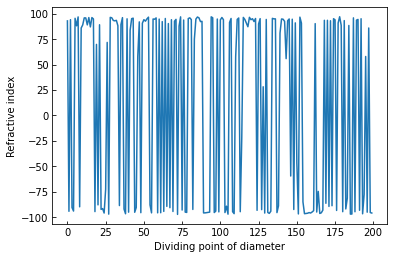

In [7]:
gan = GAN(200, 200)
gan.fit('./img100000.csv', './rindex100000.csv')

batch_size = 100
g_l1 = 'af'
g_h1 = '50'
g_ad1_1 = '_randn0.01'
g_ad1_2 = ''
g_ac1 = ''
g_l2 = 'af'
g_h2 = '100'
g_ad2_1 = '_randn0.01'
g_ad2_2 = '_genlr0.00
01_dropout0.5-3_withBatchNorm-3'
g_ac2 = ''
d_l1 = 'af'
d_h1 = '100'
d_ad1_1 = '_randn0.01'
d_ad1_2 = ''
d_ac1 = ''
d_l2 = 'af'
d_h2 = '200'
d_ad2_1 = '_randn0.01'
d_ad2_2 = ''
d_ac2 = ''
op = 'sgd'
lr = 0.1
lo = 'mse'
path = './simResults/gen{}{}{}{}{}-{}{}{}{}{}_dis{}{}{}{}{}-{}{}{}{}{}_{}{}-{}'.format\
(g_l1,g_h1,g_ad1_1,g_ad1_2,g_ac1,g_l2,g_h2,g_ad2_1,g_ad2_2,g_ac2,\
 d_l1,d_h1,d_ad1_1,d_ad1_2,d_ac1,d_l2,d_h2,d_ad2_1,d_ad2_2,d_ac2,op,lr,lo)
os.mkdir(path)

pred = gan.predict('./1.5_0.015i.csv')
y = pred.flatten()
x = np.arange(len(y))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.plot(x, y)
plt.xlabel('Dividing point of diameter')
plt.ylabel('Refractive index')
plt.savefig(path+'/'+'1.5_0.015i_pred.png', bbox_inches='tight')
plt.show()

with open(path+'/Pred.pickle', mode='wb') as f:
    pickle.dump(pred, f)
with open(path+'/Losses.pickle', mode='wb') as f:
    pickle.dump(gan.losses, f)
with open(path+'/Accs.pickle', mode='wb') as f:
    pickle.dump(gan.accs, f)
with open(path+'/Params.pickle', mode='wb') as f:
    pickle.dump(gan.params, f)

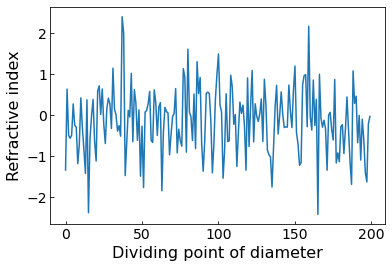

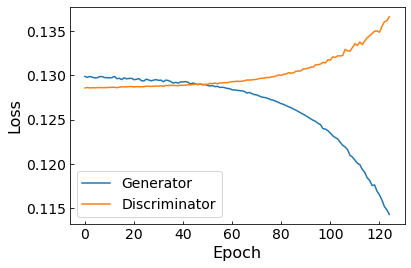

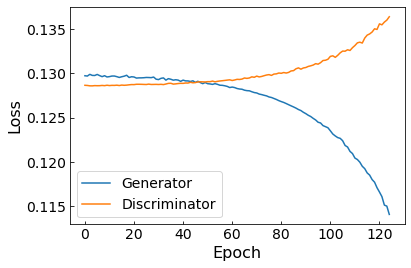

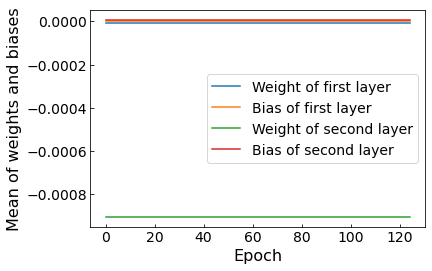

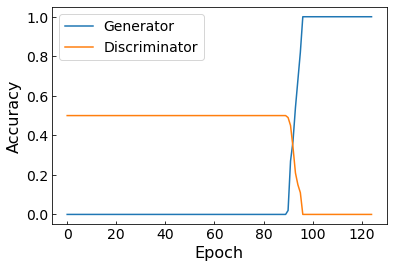

"img = np.loadtxt('./1.5_0.015i.csv',delimiter=',')\nx = np.arange(len(img))\ny = img\nplt.rcParams['xtick.direction'] = 'in'\nplt.rcParams['ytick.direction'] = 'in'\nplt.plot(x,y)\nplt.xlabel('Dividing point of screen image', fontsize=16)\nplt.ylabel('Ratio of Y coordinate to X\n of the screen image', fontsize=16)\nplt.tick_params(labelsize=14)\nplt.savefig('img.png', bbox_inches='tight')\nplt.show()\n\nimg_nondiv = np.loadtxt('1.5_0.015i_nondiv.csv',delimiter=',')\nx = img_nondiv[0]\ny = img_nondiv[1]\nplt.rcParams['xtick.direction'] = 'in'\nplt.rcParams['ytick.direction'] = 'in'\nplt.plot(x,y)\nplt.xlabel('X coordinate on the screen', fontsize=16)\nplt.ylabel('Y coordinate on the screen', fontsize=16)\nplt.tick_params(labelsize=14)\nplt.savefig('img_nondiv.png', bbox_inches='tight')\nplt.show()"

In [33]:
with open('./simResults/genaf100_randn0.01-_disaf100_randn0.01-_sgd0.001-mse/Pred_genaf100_randn0.01-_disaf100_randn0.01-_sgd0.001-mse.pickle', 'rb') as f:
    pred = pickle.load(f)
    x = np.arange(len(pred.flatten()))
    y = pred.flatten()
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.plot(x, y)
    plt.xlabel('Dividing point of diameter', fontsize=16)
    plt.ylabel('Refractive index', fontsize=16)
    plt.tick_params(labelsize=14)
    #plt.savefig('pred.png', bbox_inches='tight')
    plt.show()

with open('./simResults/genaf100_randn0.01-_disaf100_randn0.01-_sgd0.001-mse/Losses_genaf100_randn0.01-_disaf100_randn0.01-_sgd0.001-mse.pickle', 'rb') as f:
    losses = pickle.load(f)
    x = np.arange(len(losses['genTrain']))
    lossGen = losses['genTrain']
    lossDis = losses['disTrain']
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch',fontsize=16)
    ax.set_ylabel('Loss',fontsize=16)
    ax.plot(x,lossGen,label='Generator')
    ax.plot(x,lossDis,label='Discriminator')
    ax.legend(fontsize=14, loc='lower left')
    plt.tick_params(labelsize=14)
    #plt.savefig('lossTrain.png', bbox_inches='tight')
    plt.show()

with open('./simResults/genaf100_randn0.01-_disaf100_randn0.01-_sgd0.001-mse/Losses_genaf100_randn0.01-_disaf100_randn0.01-_sgd0.001-mse.pickle', 'rb') as f:
    losses = pickle.load(f)
    x = np.arange(len(losses['genTest']))
    lossGen = losses['genTest']
    lossDis = losses['disTest']
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch',fontsize=16)
    ax.set_ylabel('Loss',fontsize=16)
    ax.plot(x,lossGen,label='Generator')
    ax.plot(x,lossDis,label='Discriminator')
    ax.legend(fontsize=14, loc='lower left')
    plt.tick_params(labelsize=14)
    #plt.savefig('lossTest.png', bbox_inches='tight')
    plt.show()

with open('./simResults/genaf100_randn0.01-_disaf100_randn0.01-_sgd0.001-mse/Params_genaf100_randn0.01-_disaf100_randn0.01-_sgd0.001-mse.pickle', 'rb') as f:
    params = pickle.load(f)
    x = np.arange(len(params['gen_W1']))
    """p1_l1 = params['gen_W1']
    p2_l1 = params['gen_b1']
    p1_l2 = params['gen_W2']
    p2_l2 = params['gen_b2']"""
    p1_l1 = params['dis_W1']
    p2_l1 = params['dis_b1']
    p1_l2 = params['dis_W2']
    p2_l2 = params['dis_b2']
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch',fontsize=16)
    ax.set_ylabel('Mean of weights and biases',fontsize=16)
    ax.plot(x,p1_l1,label='Weight of first layer')
    ax.plot(x,p2_l1,label='Bias of first layer')
    ax.plot(x,p1_l2,label='Weight of second layer')
    ax.plot(x,p2_l2,label='Bias of second layer')
    ax.legend(fontsize=14)
    plt.tick_params(labelsize=14)
    #plt.savefig('paramsD.png', bbox_inches='tight')
    plt.show()

with open('./simResults/genaf100_randn0.01-_disaf100_randn0.01-_sgd0.001-mse/Accs_genaf100_randn0.01-_disaf100_randn0.01-_sgd0.001-mse.pickle', 'rb') as f:
    accs = pickle.load(f)
    x = np.arange(len(accs['genTrain']))
    #accGen = accs['genTrain']
    #accDis = accs['disTrain']
    accGenTest = accs['genTest']
    accDisTest = accs['disTest']
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch',fontsize=16)
    ax.set_ylabel('Accuracy',fontsize=16)
    #ax.plot(x,accGen,label='Generator')
    #ax.plot(x,accDis,label='Discriminator')
    ax.plot(x,accGenTest,label='Generator')
    ax.plot(x,accDisTest,label='Discriminator')
    ax.legend(fontsize=14)
    plt.tick_params(labelsize=14)
    plt.savefig('accTest.png', bbox_inches='tight')
    plt.show()

"""img = np.loadtxt('./1.5_0.015i.csv',delimiter=',')
x = np.arange(len(img))
y = img
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.plot(x,y)
plt.xlabel('Dividing point of screen image', fontsize=16)
plt.ylabel('Ratio of Y coordinate to X\n of the screen image', fontsize=16)
plt.tick_params(labelsize=14)
plt.savefig('img.png', bbox_inches='tight')
plt.show()

img_nondiv = np.loadtxt('1.5_0.015i_nondiv.csv',delimiter=',')
x = img_nondiv[0]
y = img_nondiv[1]
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.plot(x,y)
plt.xlabel('X coordinate on the screen', fontsize=16)
plt.ylabel('Y coordinate on the screen', fontsize=16)
plt.tick_params(labelsize=14)
plt.savefig('img_nondiv.png', bbox_inches='tight')
plt.show()"""